# <span style="color:#1111AA"> Michelson interferometer: Lengths and Tunings </span>

# Table of content

# Introduction

The aim of this session is to build a model of a Michelson interferometer, and investigate how its output depends on the macrospical lengths and microscopical tunings of its arms. The Michelson interferometer is the core of the interferometric GW detectors such as LIGO, Virgo, GEO and KAGRA.

** We recommend that you have done the following notebooks before starting this one:**
* 01_Introduction
    * 01_Ipython_notebook
        * [01_Ipython_notebook](../../01_Introduction/01_Ipython_notebook/01_Ipython_notebook.ipynb)
    * 02_Finesse
        * [01_Introduction](../../01_Introduction/02_Finesse/01_Introduction.ipynb)
    * 03_Pykat
        * [01_Introduction](../../01_Introduction/03_Pykat/01_Introduction.ipynb)
        * [02_Plotting_Examples](../../01_Introduction/03_Pykat/02_Plotting_Examples.ipynb)

or have corresponding basic experience of Ipython notebooks, PyKat, and Finesse. The links above only works if you started ipython notebook in the top directory of this course.

**Reading material and references:**

[1] [A. Freise, K. Strain, D. Brown, and C. Bond, "Interferometer Techniques for Gravitational-Wave Detection", *Living Reviews in Relativity* **13**, 1 (2010)](http://arxiv.org/pdf/0909.3661v3). - Living review article (more like a book) on laser interferometry in the frequency domain for detecting gravitational waves, and FINESSE.

[2] [A. Freise, D. Brown, and C. Bond, "Finesse, Frequency domain INterferomEter Simulation SoftwarE"](http://kvasir.sr.bham.ac.uk/redmine/attachments/download/131/Finesse_2.0_manual.pdf). - FINESSE-manual

[3] [FINESSE syntax reference](http://www.gwoptics.org/finesse/reference/) - Useful online syntax reference for FINESSE. Also available in the Finesse manual [2], but this online version is updated more often.

**After this session you will be able to**:
  * build a FINESSE-model of a Michelson interferometer.
  * calibrate the operating point of the FINESSE-model.

# Modelling a Michelson Interferometer using FINESSE

## Importing packages

We start by loading some necessary packages:

In [1]:
import numpy as np                         # Importing numpy
import matplotlib                          # Importing matplotlib, so we can plot figures
import matplotlib.pyplot as plt                   
from pykat import finesse                  # Importing the pykat.finesse package
from pykat.commands import *               # Importing all packages in pykat.commands.
from IPython.display import display, HTML  # Allows us to display HTML.

# Telling the notebook to make plots inline.
%matplotlib inline      
# Initialises the PyKat plotting tool. Change the dpi-value to make plots appear smaller/bigger on your screen.
pykat.init_pykat_plotting(dpi=90)          

                                              ..-
    PyKat 1.0.0           _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,  
   `^-....____:   +.      www.gwoptics.org/pykat



## Optical Layout

Below is the optical layout of a simple Michelson. The laser beam is splitted by the beam splitter (BS) and propagates in both X and Y arms. Gravitational wave detectors are calibrated such that when the two beams are recombined at the beam splitter, they interfere (close to) destructively at the output port (a.k.a. south port, assymetric port, dark port), and they intefere constructively at the west port (a.k.a. symmetric port, bright port). Mirror movements or gravitational waves change the differential arm lenghth $\Delta L = L_y - L_x$, which produces a signal at the output port where we place a photodiode. See section 5.2 in the review article if you want a longer description of the Michelson interferometer.

<img src="files/michelson.svg" style="width: 400px;"/>

## Lengths and tunings in FINESSE

If the beams interfere constructively or destructively at the beam splitter depends on the difference in optical path lengths for the two arms, modulo the laser wavelength. Thus, for the light of a Nd:YAG laser ($\lambda = 1064$ nm), length differences of less than 1 μm are of interest. Some orders of magnitude:
  * LIGO peak senitivity in meters: $\sim 10^{-20}$ m
  * LIGO cavity mirror postion control accuracy: $< 10^{-12}$ m
  * LIGO arm cavity length: $\sim 10^3$ m
  * relative numerical accuracy of floating point numbers: $10^{-15}$

Because of the large differences in order of magntiude, it is convenient to split distances D between optical components into two parameters: one is the macroscopic ‘length’ L defined now as that multiple of the default wavelength $\lambda_0$ yielding the smallest difference to D. The second parameter is the microscopic tuning that is defined as the remaining difference between L and D. This tuning is usually given as a phase "phi" (in radians) with 2π referring to one wavelength. In FINESSE tunings are entered and printed in degrees, so that a tuning of phi = 360 degrees refers to a change in the position of the component by one wavelength ($\lambda_0$). In FINESSE macroscopical lengths are assigned to space components (keyword `s`) and microscopiacal tunings are assigned to optical components such as mirrors, beam splitters, lenes etc. You can read more about how lengths and tuning are defined in FINESSE in section 2.5 in Freise et al. [1]. 

## Building the FINESSE-model

Lets build an optical model in FINESSE matching the setup in the figure above.

In [2]:
basekat = finesse.kat()    # Initialising Finesse
basekat.verbose = False    # Tells Finesse to talk less

basecode = """

## Parameters ##
const Pin 1M         # Laser power [W]
const LX 4000        # Length of X arm [m]
const LY 4000        # Length of Y arm [m]

## Laser & Beam splitter ##
l laser $Pin 0 n0                         # Laser
s s1 1 n0 nbsc                            # Space from laser to beam splitter
bs BS 0.5 0.5 0 45 nbsc nbsY nbsX nbsd    # Central 50/50 beam splitter with 0 tuning and 45 deg angle of incidence.

## X arm ##
s LX $LX nbsX nmX1         # Space between beam splitter and mirror mX
m mX 1 0 0 nmX1 nmX2       # Test mass mirror mX (reflectivity 1, 0 transmissivity, and 0 deg tuning)

## Y arm ##
s LY $LY nbsY nmY1         # Space between beam slitter and mirror mY
m mY 1 0 0 nmY1 nmY2       # Test mass mirror mY (reflectivity 1, 0 transmissivity, and 0 deg tuning)

## Output port ##
s sout 1 nbsd nout         # Space from BS to a measurement device not yet defined

"""
basekat.parseCommands(basecode)  # passing the input text to the Finesse object

We call this kat-object *basekat* since it describes the core optics of the system we will investigate throughout this notebook. The above basekat-object will not be altered much throughout the Notebooks about the Michelson interferometer, however, what we measure and the specific simulation instructions will. Therefore we can copy the above basekat objet by using `deepcopy`, and then add on the specific simulation instructions.

## Simulation example: Differential arm length tuning

Now we add the simulation instrctions. Here we will look at how the output power varies with differential arm length (DARM) tuning. 

In [4]:
kat1 = deepcopy(basekat)
code = """

## Detectors ##
pd pout nout                     # Photo diode at the output port

## Simulation instructions ##

# Varying the differential arm length
xaxis mX phi lin -90 90 200      # Changes the parameter phi of mX from -90 to 90 in 200 linear steps. 

put* mY phi $mx1                  # Puts the negative (m in $mx1 is keyword for minus) value from the 
                                 # x-axis to the tuning of mY.
yaxis abs                        # Outputs the amplitude of their measured quantity.
"""
# Parsing the FINESSE code
kat1.parseCommands(code)
# Running the simulation
out1 = kat1.run()

                                              ..-
    PyKat 0.8.10          _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,  
   `^-....____:   +.      www.gwoptics.org/pykat

Keyboard interrupt caught, stopped simulation.


The line `put* mY phi $mx1` might be new to you, here follows a short explanation: 

Parameters fronted by an `$` are internal variables in Finesse, so here `$mx1` refers to the current value of the xaxis times (-1). Without the `m` in front of `x1` there would be no factor of (-1). The put command sets the position paramter `phi` of mirror `mY` to this value. Therefore, by using the put command here, we elongate one arm while shortening the other. The star (*) after `put` adds tells FINESSE to add the value instead of instead of overwriting it, which would be the case without the star. In this case it doesn't matter which we use though, but we use the star here for convenience later.

## Simulation output:

In [5]:
out1 = kat1.run() # run Finesse, the output will be stored in 'out1'

The result of the run is now stored in the object `out1`. We can plot the output by using:

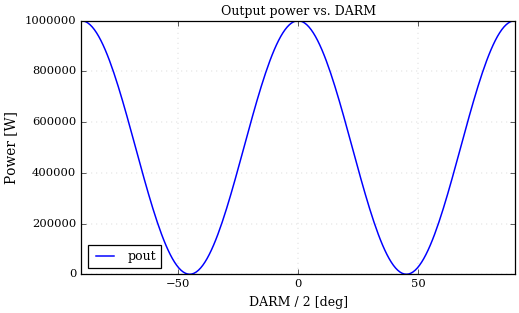

In [6]:
fig1 = out1.plot(xlabel="DARM / 2 [deg]", 
                 ylabel="Power [W]", 
                 title="Output power vs. DARM")

# Tasks: 

## Calibrate the operating point to the dark fringe

For the current setup we have a power peak when not chaning anything, i.e., at zero on the x-axis in the figure above. But gravitational wave detectors operate close to the dark fringe, that is where the power is zero. Change **one** parameter in the setup to make the setup initillay yield zero output power.

**Answer:**

## Detune the operating point

Your setup now yields 0 power if nothing is changed, however, the current gravitatitonal wave detctors don't operate exactly at the dark fringe, but sligthly off it. The reason for this lays outside the scope of this notebook: we need a *local oscillator* that beats with the signal sidebands, created in the the arms by gravitational waves, to see the the signal sidebands. Don't worry if you don't understand the former sentence.

Change the tuning slightly of one of the arm mirrors so that we get 10 mW as output. What length offset does this tuning offset corresponds to? Why not a larger number than 10 mW?

**Comment**: In case you want to use a <a href="http://docs.scipy.org/doc/scipy/reference/optimize.html">`scipy.optimize`</a> tool (I would suggest `minimize_scalar()`), FINESSE need can be told to compute results for one data point per run by using the command `noxaxis` in the FINESSE-code, or by making use of PyKat by typing `kat.noxaxis=True`..

**Answer:**

# Macroscopical arm length difference

Investigate the response of the Michelson interferometer to a change in the macroscopical arm length difference, i.e., change the lengths of the space components. What do you see and why?

**Answer:**

# Macroscopical arm length difference and change in frequency

In FINESSE the frequency of a laser field can be specified in two different ways: 

* One can set the absolute frequency of the carrier laser field by specifiying the carrier wavelenght. This can be done either by chaning the paramter lambda in the *kat.ini* file located in your FINESSE directory, or by using the finesse code line '`lambda 1550n`', or in PyKat by using `kat.lambda0 = 1550.0e-9`. In the last 2 examples we used 1550 nm as the new wavelength. 

* One can specify a frequency offset relative to the carrier by setting the frequency offset paramter `f` of the laser component.

Your task it to change both the absolute frequency and the relative frequency, but in separate runs, and see how these parameters changes the result of task 3.3. What do you see, and why? 

*Hint: Remember that FINESSE defines macroscopical lengths as integer multiples of the carrier wavelength.*

**Answer:**

# Tasks with answers: 

## Calibrate the operating point to the dark fringe

For the current setup we have a power peak when not chaning anything, i.e., at zero on the x-axis in the figure above. But gravitational wave detectors operate close to the dark fringe, that is where the power is zero. Change **one** parameter in the setup to make the setup initillay yield zero output power.

**Answer:**

Since we have constructive inteference when both the arm mirrors have zero tuning, we need to offset the tuning of one of the arm mirrors by 90 degrees ($\lambda/4$), which yields a roundtrip difference between the arms of $\lambda/2$, to get destructive interference. We can do this either by copy-pasting both the `basekat` and the `kat1` code from above, and make the change directly in the FINESSE-code, or we can make use of PyKat.

**Solution alternative (a):** Using FINESSE-code. 

The solution shown in the next cell is obtained by:
* Copy-pasting the code of both `basekat` and `kat1` from above.
* Change the tuning of the mirror `mY` from 0 to 90 degress.

An important note:
* The star (*) after the put command is now important, because without it, the 90 degrees offset would be overwritten. 

In [7]:
kat2a = finesse.kat()    # Initialising Finesse
kat2a.verbose = False    # Tells Finesse to talk less

code = """
## Parameters ##
const Pin 1M         # Laser power [W]
const LX 4000        # Length of X arm [m]
const LY 4000        # Length of Y arm [m]

## Laser & Beam splitter ##
l laser $Pin 0 n0                         # Laser
s s1 1 n0 nbsc                            # Space from laser to beam splitter
bs BS 0.5 0.5 0 45 nbsc nbsY nbsX nbsd    # Central 50/50 beam splitter with 0 tuning and 45 deg angle of incidence.

## X arm ##
s LX $LX nbsX nmX1         # Space between beam splitter and mirror mX
m mX 1 0 0 nmX1 nmX2       # Test mass mirror mX (reflectivity 1, 0 transmissivity, and 0 deg tuning)

## Y arm ##
s LY $LY nbsY nmY1         # Space between beam slitter and mirror mY
m mY 1 0 90 nmY1 nmY2      # Test mass mirror mY (reflectivity 1, 0 transmissivity, and 90 deg tuning)

## Output port ##
s sout 1 nbsd nout         # Space from BS to a measurement device not yet defined


## Detectors ##
pd pout nout               # Photo diode at the output port

## Simulation instructions ##

# Varying the differential arm length
xaxis mX phi lin -90 90 200      # Changes the parameter phi of mX from -90 to 90 in 200 linear steps. 

put* mY phi $mx1                 # Adds the negative (m in $mx1 is keyword for minus) value from the 
                                 # x-axis to the tuning of mY.
yaxis abs                        # Outputs the amplitude of their measured quantity.
"""
# Parsing the FINESSE code
kat2a.parseCommands(code)
# Running the simulation
out2a = kat2a.run()

** Solution alternative (b):** Making use of PyKat.
* Deepcopy the `kat1`-object.
* Use PyKat to change the value of the tuning of the mirror `mY`.

In [8]:
# Copying the kat1-object
kat2b = deepcopy(kat1)
# Setting the tuning of the mirror mY.
kat2b.mY.phi = 90
# Running the simulation.
out2b = kat2b.run() # run Finesse, the output will be stored in 'out'

**Plotting** both solution (a) and (b), which must be identical:

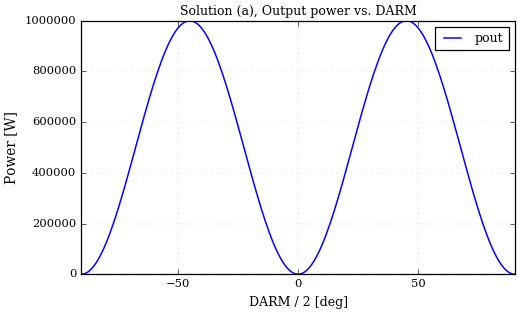

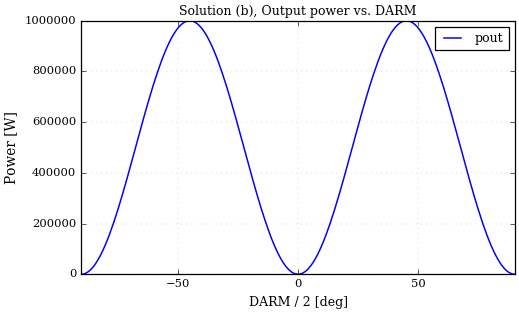

In [9]:
# Plotting solution alternative (a)
fig2a = out2a.plot(xlabel="DARM / 2 [deg]", 
                   ylabel="Power [W]", 
                   title="Solution (a), Output power vs. DARM")

# Plotting solution alternative (b)
fig2b = out2b.plot(xlabel="DARM / 2 [deg]", 
                   ylabel="Power [W]", 
                   title="Solution (b), Output power vs. DARM")

## Detune the operating point

Your setup now yields 0 power if nothing is changed, however, the current gravitatitonal wave detctors don't operate exactly at the dark fringe, but sligthly off it. The reason for this lays outside the scope of this notebook: we need a *local oscillator* that beats with the signal sidebands, created in the the arms by gravitational waves, to see the the signal sidebands. Don't worry if you don't understand the former sentence.

Change the tuning slightly of one of the arm mirrors so that we get 10 mW as output. What length offset does this tuning offset corresponds to? Why not a larger number than 10 mW?

**Comment**: In case you want to use a <a href="http://docs.scipy.org/doc/scipy/reference/optimize.html">`scipy.optimize`</a> tool (I would suggest `minimize_scalar()`), FINESSE need can be told to compute results for one data point per run by using the command `noxaxis` in the FINESSE-code, or by making use of PyKat by typing `kat.noxaxis=True`..

**Answer:**

One way of solving this is to manually sweeping the differential arm length tuning just as before, and successively "zoom" in around the x-axis region that contains the output power of 10 mW. However, below we make use of the `scipy.optimize` function called `minimize_scalar()`.

* Setup the FINESSE model to initially operate at the dark fringe as in 3.1., and tell FINESSE to only output one value per run by using the noxaxis command, which is necessary when using `minimize_scalar()`.

In [10]:
kat3 = deepcopy(basekat)
kat3.mY.phi = 90
code = '''
## Detectors ##
pd pout nout                     # Photo diode at the output port

## Simulation instructions ##
noxaxis                          # Telling FINESSE to only simulate the current setup.
yaxis abs                        # Outputs the amplitude of the quantiteis measured by the photo diode.
'''
# Parsing the FINESSE code
kat3.parseCommands(code)

Test-running and printing power to check if it is zero (or extremely close to zero).

In [11]:
# Running once to test
out3_test = kat3.run()
# Printing
print('Pout =  {0} W'.format(out3_test['pout']))

Pout =  3.74939945665464e-27 W


* Next step is to write a cost function that is minimised when this task is solved. As input we have the tuning of the mirror `mX`, and as output whe have the magnitude of the difference between the output power and 10 mW for this input tuning.

In [12]:
# Copying kat3
kat3b = deepcopy(kat3)
# Cost function to minimise
def f(x):
    kat3b.mX.phi = x       # Setting new tuning of mirror mX
    out3b = kat3b.run()     # Running the simulation
    # Printing values to screen to monitor the process
    print('Tuning: {0} \t \t Power: {1}'.format(x, out3b['pout']))
    # Returning the absolute value of the deviation from 10 mW.
    return np.abs(out3b['pout'] - 0.01)

* Uisng the `scipy.optimise` function `minimize_scalar()` to find the solution.

In [13]:
import scipy.optimize as op

# Minimising the function f using the method Bounded, checking for solution between tunings of 0 and 1 degree,
# using maximally 100 iterations, using x-value tolerance of 10^(-8). 
sol = op.minimize_scalar(f, method = 'Bounded', bounds=(0,1), 
                         options={'maxiter': 100, 'xatol': 1e-05})

# Storing the obtained detuning
detuning = sol.x
# Printing important information
print()
print('Success: {0}. {1}'.format(sol.success, sol.message))

Tuning: 0.3819660112501051 	 	 Power: 44.4424242010141
Tuning: 0.6180339887498948 	 	 Power: 116.348988150856
Tuning: 0.2360679774997897 	 	 Power: 16.9756509272537
Tuning: 0.14589803375031546 	 	 Power: 6.48414434936049
Tuning: 0.09016994374947425 	 	 Power: 2.47672606192964
Tuning: 0.055728090000841224 	 	 Power: 0.946025657528926
Tuning: 0.03444185374863304 	 	 Power: 0.361349717370799
Tuning: 0.0212862362522082 	 	 Power: 0.138023320485246
Tuning: 0.013155617496424847 	 	 Power: 0.0527202186843213
Tuning: 0.008130618755783355 	 	 Power: 0.0201373318618009
Tuning: 0.0050249987406414945 	 	 Power: 0.00769177636038533
Tuning: 0.003991915858772995 	 	 Power: 0.00485419805457298
Tuning: 0.005587477045705848 	 	 Power: 0.00951012527353279
Tuning: 0.0065588707407479244 	 	 Power: 0.0131042713518028
Tuning: 0.005724747878595656 	 	 Power: 0.00998314693900542
Tuning: 0.006043354461144479 	 	 Power: 0.0111252779218936
Tuning: 0.005769537454130088 	 	 Power: 0.0101399713455592
Tuning: 0.00570

* Testing the obtained solution. It shouldn't matter which mirorr we apply the extra detuning too, thus we test this by adding the obtained detuning to the mirror mY.

In [15]:
# Copying kat3
kat3c = deepcopy(kat3)
# Adding the detuning to the tuning of the mY mirror
kat3c.mY.phi = kat3c.mY.phi.value + detuning
# Running simulation
out3c = kat3c.run()
# Printing results
print('Pout = {} mW'.format(1000.0*out3c['pout']))

Pout = 10.0013329711608 mW


## Macroscopical arm length difference

Investigate the response of the Michelson interferometer to a change in the macroscopical arm length difference, i.e., change the lengths of the space components. What do you see and why?

**Answer:**

Since the macroscopical arm length is defined as an integer multiple of the the wavelength, we don't expect to see any change in power when changing this parameter. But lets look at it. Below, this is done in the following steps:
* Copy `basekat` using deepcopy
* Add code for detectors and simulaiton instructions
    * Vary the length of the x-arm between 3000 m and 5000 m.
    * Use a function (keyword `func`) together with `put` to change the length of the other arm in the opposite direction.

In [16]:
kat4 = deepcopy(basekat)
code = '''
## Detectors ##
pd pout nout                     # Photo diode at the output port

## Simulation instructions ##
xaxis* LX L lin -1000 1000 200      # Sweeps the parameter L of LX from 3000m to 5000m in 200 linear steps. 
func ylen = 4000-$x1                # Function ranging betwen 1000 and -1000 ($x1 goes from 3000 to 5000)
put* LY L $ylen                     # Adds the value in ylen to the length L of LY, i.e., length of LY goes 
                                    # form 5000 to 3000

yaxis abs                        # Outputs the amplitude of measured quantities.
noplot ylen                      # Telling FINESSE and PyKat to not plot ylen (by default it does)
'''

# Parsing the FINESSE fcode
kat4.parseCommands(code)
# Running the simulation
out4 = kat4.run()

Plotting the result:

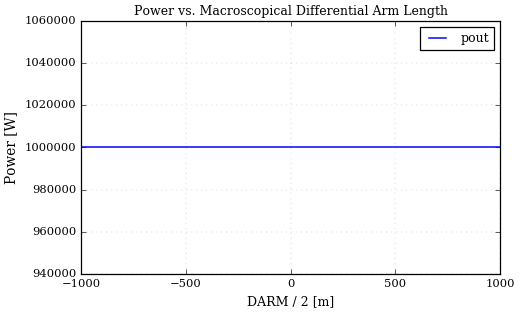

In [17]:
fig4 = out4.plot(ylabel='Power [W]',
                 xlabel='DARM / 2 [m]',
                 title='Power vs. Macroscopical Differential Arm Length')

As we can see, the power remains constant as expected. The above seems to indicate that the macroscopic arm-length difference plays no role in the Michelson output signal. However, this is only correct for a monochromatic laser beam with infinite coherence length, and as long as we only consider one frequency component. In real interferometers, care must be taken that the arm-length difference is well below the coherence length of the light source. 

In gravitational-wave detectors the macroscopic arm-length difference is an important design feature: it is kept very small in order to reduce coupling of laser noise into the output but needs to retain a finite size to allow the transfer of phase modulation sidebands from the input to the output port. 

## Macroscopical arm length difference and change in frequency

In FINESSE the frequency of a laser field can be specified in two different ways: 

* One can set the absolute frequency of the carrier laser field by specifiying the carrier wavelenght. This can be done either by chaning the paramter lambda in the *kat.ini* file located in your FINESSE directory, or by using the finesse code line '`lambda 1550n`', or in PyKat by using `kat.lambda0 = 1550.0e-9`. In the last 2 examples we used 1550 nm as the new wavelength. 

* One can specify a frequency offset relative to the carrier by setting the frequency offset paramter `f` of the laser component.

Your task it to change both the absolute frequency and the relative frequency, but in separate runs, and see how these parameters changes the result of task 3.3. What do you see, and why? 

*Hint: Remember that FINESSE defines macroscopical lengths as integer multiples of the carrier wavelength.*

**Answer:**

When setting the absolute wavelength of the laser, all macroscopical length are defined as integer multiples of the new wavelength, hence, no phase changes and we expect the plot to remain the same as in task 3.3. 

However, when changing the relative frequency $\Delta f$, the macroscopical lengths are no longer defined as multiple integers of the laser field in use. Thus, the field in an arm returning to the beam splitter is generally phase shifted relative to the field entering the arm at the beam splitter, even without non-zero tuning of the mirrors. The roundtrip phase change in an arm is given by

\begin{align}
\varphi_{rt} = -2\left(\frac{2\pi \Delta f L}{c} + \phi \right),
\end{align}

where $\phi$ is the tuning in radians, $c$ is the speed of light, and $L$ is the macroscopical length of the arm. From this expression, we can clearly see that the roundrip phase depends on the macroscopical length in FINESSE as long as the laser frequency offset $\Delta f$ is nonzero. And since we change the arm length difference, the roundtrip change in each arm must in general be different from each other, so we expect the output power to change with chaning macroscopical arm length difference when we use a laser frequency offset.

**Solution with changed absolute frequency**. Changing from default of $\lambda_0 = 1064$ nm to $\lambda_0=1550$ nm.
* Copying basekat
* Copy/paste the FINESSE-code from task 3.3.
* Setting new $\lambda_0$ to 1550 nm in the FINESSE code using the command `lambda`. You can also test doing this directly in your *kat.ini* file, and by using PyKat as `kat5.lambda0 = 1.55e-6`.

In [18]:
# Copying basekat
kat5 = deepcopy(basekat)
# Setting carrier wavelength to 1550 nm.
code = """
# Setting new reference wavelength
lambda 1550n

## Detectors ##
pd pout nout                     # Photo diode at the output port

## Simulation instructions ##
xaxis* LX L lin -1000 1000 200      # Sweeps the parameter L of LX from 3000m to 5000m in 200 linear steps. 
func ylen = 4000-$x1                # Function ranging betwen 1000 and -1000 ($x1 goes from 3000 to 5000)
put* LY L $ylen                     # Adds the value in ylen to the length L of LY, i.e., length of LY goes 
                                    # form 5000 to 3000

yaxis abs                        # Outputs the amplitude of measured quantities.
noplot ylen                      # Telling FINESSE and PyKat to not plot ylen (by default it does)
"""
# Parsing the FINESSE fcode
kat5.parseCommands(code)
# Running the simulation
out5 = kat5.run()

Plotting results:

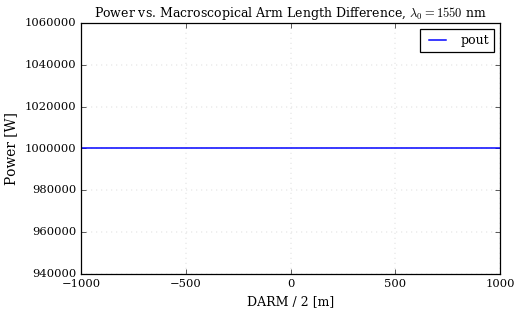

In [19]:
fig5 = out5.plot(ylabel='Power [W]', 
                 xlabel='DARM / 2 [m]', 
                 title='Power vs. Macroscopical Arm Length Difference, $\lambda_0 = 1550$ nm')

The output power does not depend on the macroscopical arm length difference when the carrier frequency is changed.

** Solution with changed offset frequency:** Offsetting to 100 kHz.
* Copy basekat
* Copy/paste code from task 3.3.
* Use PyKat to set the laser frequency offset to 100 kHz. You can also copy/paste the `basekat`-code and set the offset directly in the FINESSE-code as well.

In [20]:
# Copying basekat
kat6 = deepcopy(basekat)
# Setting offset frequency to 100 kHz.
kat6.laser.f = 1.0e5
code = """
## Detectors ##
pd pout nout                     # Photo diode at the output port

## Simulation instructions ##
xaxis* LX L lin -1000 1000 200      # Sweeps the parameter L of LX from 3000m to 5000m in 200 linear steps. 
func ylen = 4000-$x1                # Function ranging betwen 1000 and -1000 ($x1 goes from 3000 to 5000)
put* LY L $ylen                     # Adds the value in ylen to the length L of LY, i.e., length of LY goes 
                                    # form 5000 to 3000

yaxis abs                        # Outputs the amplitude of measured quantities.
noplot ylen                      # Telling FINESSE and PyKat to not plot ylen (by default it does)
"""
# Parsing the FINESSE fcode
kat6.parseCommands(code)
# Running the simulation
out6 = kat6.run()

Plotting results

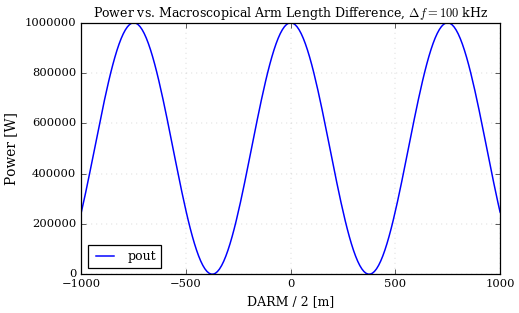

In [21]:
fig6 = out6.plot(ylabel='Power [W]', 
                 xlabel='DARM / 2 [m]', 
                 title='Power vs. Macroscopical Arm Length Difference, $\Delta f = 100$ kHz')

When offsetting the laser frequency, we create a dependency on the macroscopial arm length difference, just as we expected.

# Summary

In this session we have:
* built a FINESSE model of a Michelson interferometer
* investigated how the power depends on the microscopical arm length difference
* calibrated the operating point to the dark fringe
* detuned the operating point to give a specific amount of output power. 
* investigated how the output power depends on the macroscopical arm length difference.
* investigated how the output power depends on the macroscopical arm length difference when we change the reference carrier frequency, and offset the laser frequency.

In the [next session](02_Mirror_asymmetries.ipynb) we will look into how the Michelson depends on Mirror asymmetries. 